In [95]:
import os
import copy
import numpy as np
import pandas as pd
import getpass
import cPickle as pickle
import pylab as plt
%matplotlib inline
import GPy
import itertools
import random
from scipy.stats import pearsonr
from sklearn.model_selection import KFold

datasets = '/home/'+ getpass.getuser() +'/Datasets/'
print datasets

## This data is the occupation skills vectors, weighted by Task Importance per DWA
file_name = 'tasks_by_skills_2018_v4.p'
p = os.path.join(datasets, 'FoEmployment/Analysis_of_ONET_Tasks', file_name)
with open(p, 'r') as f:
    data = pickle.load(f)
(X, test, y) = data

## This data is further weighted by Task Importance per Occupation
#/home/scpd/Datasets/FoEmployment/Analysis_of_ONET_Tasks/tasks_by_skills_v3_o.p
p = os.path.join(datasets, 'FoEmployment/Analysis_of_ONET_Tasks/tasks_by_skills_2018_v4_o.p')
with open(p, 'r') as f:
    data_o = pickle.load(f)
(X_o, test_o, y_o) = data_o

#Misc settings
ms = 11  # marker size in plots

random.seed =  6   # random seed


/home/scpd/Datasets/


In [2]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [4]:
def learn_a_GP(x_train, y_train):
    in_dims = x_train.shape[1]
    
    k1 = GPy.kern.RBF(in_dims, variance=1, lengthscale=0.4)
    k2 = GPy.kern.Matern32(in_dims, 0.5, 0.2)
    # Sum of kernels
    k = k1 + k2
    m = GPy.models.GPRegression(x_train, y_train, k)
    m.optimize()
    return m

In [11]:
val_size = 0.10
cols = test.columns[2:]
in_dims = cols.shape[0]

# Create a Validation set
msk = [i for i in range(X.shape[0])]

In [5]:
# # Investigate which combination of standard Kernels explains the data best:
n_validation_set = int(np.floor(X.shape[0]*val_size))
print "Val set: ", msk[:n_validation_set]
# random.shuffle(msk)

x_train = X.iloc[msk[n_validation_set:]][cols].as_matrix()
x_valid = X.iloc[msk[:n_validation_set]][cols].as_matrix()

y_train = y.values[msk[n_validation_set:]].reshape(x_train.shape[0], 1)
y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)

x_test = test[cols].as_matrix()
kerns = [GPy.kern.RBF(in_dims), GPy.kern.Matern32(in_dims), GPy.kern.Matern52(in_dims), GPy.kern.MLP(in_dims), 
         GPy.kern.Exponential(in_dims), GPy.kern.Bias(in_dims)]

models, errs = [], []
print "\nSingle Kernels: "
for cnt, k in enumerate(kerns):
    print cnt
    m = GPy.models.GPRegression(x_train, y_train, k)
    m.optimize()    
    models.append(m)
    y_pred, Vp = m.predict(x_valid, full_cov=False)
    err = rmse(y_valid, y_pred)
    errs.append(err)
    print "RMS Error is: %0.3f vs %0.3f. -LLhood = -%s" % (err, rmse(y_valid, np.mean(y_valid)), m.objective_function()) 

print "\nSum/Multiply Kernels: "
for cnt, (i, j) in enumerate(itertools.combinations_with_replacement(kerns, 2)):
    for sum_or_mult in [0,1]:
        if sum_or_mult:
            m = GPy.models.GPRegression(x_train, y_train, i+j)
        else:
            if i==j: continue
            m = GPy.models.GPRegression(x_train, y_train, i*j)
        m.optimize()    
        models.append(m)
        y_pred, Vp = m.predict(x_valid, full_cov=False)
        err = rmse(y_valid, y_pred)
        errs.append(err)
        rand_err = rmse(y_valid, np.mean(y_valid))
        print "RMS Error is: %0.3f vs %0.3f. -LLhood = -%s" % (err, rand_err, m.objective_function()) 

print "\nBest:"   
print errs[np.argmin(errs)]
print models[np.argmin(errs)]

Val set:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

Single Kernels: 
0
RMS Error is: 0.517 vs 0.626. -LLhood = -264.38862128
1
RMS Error is: 0.498 vs 0.626. -LLhood = -263.466360923
2
RMS Error is: 0.509 vs 0.626. -LLhood = -263.284687681
3
RMS Error is: 0.463 vs 0.626. -LLhood = -230.948607357
4
RMS Error is: 0.515 vs 0.626. -LLhood = -266.115197469
5
RMS Error is: 0.627 vs 0.626. -LLhood = -281.944246555

Sum/Multiply Kernels: 
RMS Error is: 0.517 vs 0.626. -LLhood = -264.38862128
RMS Error is: 0.499 vs 0.626. -LLhood = -263.405767296
RMS Error is: 0.495 vs 0.626. -LLhood = -263.419413872
RMS Error is: 0.509 vs 0.626. -LLhood = -263.284693102


 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/paramz-0.7.3-py2.7.egg/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


RMS Error is: 0.512 vs 0.626. -LLhood = -263.222722568
RMS Error is: 0.463 vs 0.626. -LLhood = -230.948226095
RMS Error is: 0.462 vs 0.626. -LLhood = -230.368609217
RMS Error is: 0.515 vs 0.626. -LLhood = -266.115104657
RMS Error is: 0.515 vs 0.626. -LLhood = -266.115347989
RMS Error is: 0.627 vs 0.626. -LLhood = -281.883285842
RMS Error is: 0.627 vs 0.626. -LLhood = -281.883294944
RMS Error is: 0.498 vs 0.626. -LLhood = -263.46636093
RMS Error is: 0.509 vs 0.626. -LLhood = -263.284930647
RMS Error is: 0.512 vs 0.626. -LLhood = -263.222957547
RMS Error is: 0.464 vs 0.626. -LLhood = -230.950415474
RMS Error is: 0.464 vs 0.626. -LLhood = -230.363993052
RMS Error is: 0.514 vs 0.626. -LLhood = -266.110831871
RMS Error is: 0.515 vs 0.626. -LLhood = -266.115352596
RMS Error is: 0.498 vs 0.626. -LLhood = -263.466360924
RMS Error is: 0.498 vs 0.626. -LLhood = -263.466492274
RMS Error is: 0.509 vs 0.626. -LLhood = -263.284687678
RMS Error is: 0.463 vs 0.626. -LLhood = -230.944877312
RMS Error i

 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/GPy/kern/src/stationary.py:160: RuntimeWarning:overflow encountered in divide
 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/GPy/kern/src/stationary.py:482: RuntimeWarning:overflow encountered in multiply
 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/GPy/kern/src/stationary.py:482: RuntimeWarning:overflow encountered in square
 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/GPy/kern/src/stationary.py:482: RuntimeWarning:invalid value encountered in multiply


RMS Error is: 0.487 vs 0.626. -LLhood = -269.494549116
RMS Error is: 0.476 vs 0.626. -LLhood = -268.004668129
RMS Error is: 0.463 vs 0.626. -LLhood = -230.948607357
RMS Error is: 0.463 vs 0.626. -LLhood = -230.947924724
RMS Error is: 0.462 vs 0.626. -LLhood = -230.364049756
RMS Error is: 0.473 vs 0.626. -LLhood = -261.906946086
RMS Error is: 0.462 vs 0.626. -LLhood = -230.370429219
RMS Error is: 0.515 vs 0.626. -LLhood = -268.785704561
RMS Error is: 0.515 vs 0.626. -LLhood = -268.785713234
RMS Error is: 0.515 vs 0.626. -LLhood = -268.785229279
RMS Error is: 0.627 vs 0.626. -LLhood = -281.944246548

Best:
0.461644537791

Name : GP regression
Objective : 230.370429219
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  sum.mlp.variance         |       1.81898020974  |      +ve      |        
  sum.mlp.weight_variance  |       4266490.74185  |      +ve      |        
  sum.m

In [6]:
kers = ['RBF', 'Mat32', 'Mat52', 'MLP', 'Exp', 'Bias']
labels = copy.copy(kers)
for cnt, (i, j) in enumerate(itertools.combinations_with_replacement(kers, 2)):   
    labels.append("%s + %s" %(i, j))
    if i==j: continue
    labels.append("%s x %s" %(i, j))

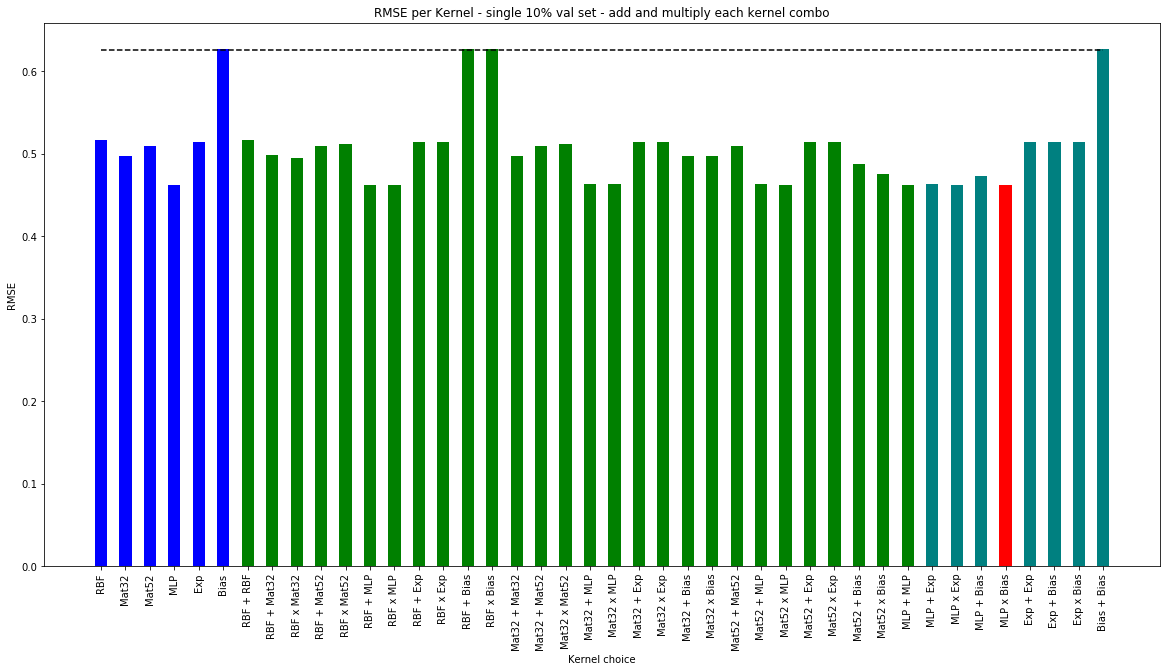

In [7]:
x = range(len(errs))
best_ind = np.argmin(errs)
colours = ["blue"]*len(kers) + ["green"]*28 + ["teal"]*21 
colours[best_ind] = "red" 
fig = plt.figure(figsize=(20,10))

plt.bar(x, errs, 0.5, color = colours)
plt.xticks(x, labels, rotation = 90)
plt.ylabel('RMSE')
plt.xlabel('Kernel choice')
plt.title('RMSE per Kernel - single 10% val set - add and multiply each kernel combo')

# horizontal line indicating the average
plt.plot([0, x[-1]], [rand_err, rand_err], "k--")
plt.show()

# Further investigate the MLP Kernel: 

$$k(x,y) = \sigma^{2}\frac{2}{\pi }  \text{asin} \left ( \frac{ \sigma_w^2 x^\top y+\sigma_b^2}{\sqrt{\sigma_w^2x^\top x + \sigma_b^2 + 1}\sqrt{\sigma_w^2 y^\top y \sigma_b^2 +1}} \right )$$


 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


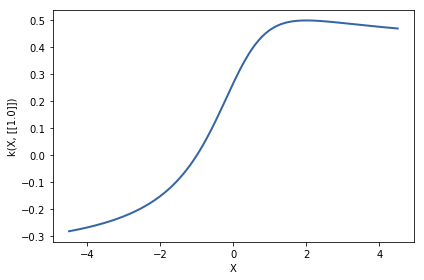

In [6]:
k = GPy.kern.MLP(1)#+GPy.kern.Linear(1,variances=1e-100)
k.plot()

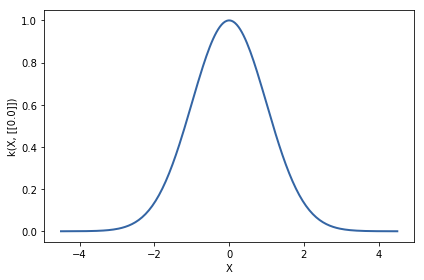

In [7]:
k = GPy.kern.RBF(1)
k.plot()


In [9]:
# # Investigate which combination of standard Kernels explains the data best:
n_validation_set = int(np.floor(X.shape[0]*val_size))
print "Val set: ", msk[:n_validation_set]
# random.shuffle(msk)

x_train = X.iloc[msk[n_validation_set:]][cols].as_matrix()
x_valid = X.iloc[msk[:n_validation_set]][cols].as_matrix()

y_train = y.values[msk[n_validation_set:]].reshape(x_train.shape[0], 1)
y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)
x_test = test[cols].as_matrix()

kerns = [GPy.kern.RBF(in_dims), GPy.kern.Matern32(in_dims), GPy.kern.Matern52(in_dims), GPy.kern.MLP(in_dims), 
         GPy.kern.Exponential(in_dims), GPy.kern.Bias(in_dims)]

mlp_kers = ['RBF', 'Mat32', 'Mat52', 'Exp', 'Bias']  # Join MLP to these kernels
MLP_kers = [GPy.kern.RBF(in_dims), GPy.kern.Matern32(in_dims), GPy.kern.Matern52(in_dims), 
            GPy.kern.Exponential(in_dims), GPy.kern.Bias(in_dims)]

models, errs = [], []

for fix_h_noise in [0, 1]:  # Optimised vs Fixed (random) Hetro Noise
    
    print "\nSingle Kernels: "
    for cnt, k in enumerate(kerns):
        print cnt, 
        m = GPy.models.GPHeteroscedasticRegression(x_train, y_train, k)
        if fix_h_noise: m.het_Gauss.variance.fix() #Fix the noise term
        m.optimize()    
        models.append(m)
        y_pred, Vp = m._raw_predict(x_valid)
        err = rmse(y_valid, y_pred)
        errs.append(err)
        print "RMS Error is: %0.3f vs %0.3f. %s" % (err, rmse(y_valid, np.mean(y_valid)), m.objective_function()) 

    print "\nSum/Multiply Kernels: "
    for cnt, j in enumerate(MLP_kers):
        for sum_or_mult in [0,1]:
            if sum_or_mult:
                m = GPy.models.GPHeteroscedasticRegression(x_train, y_train, GPy.kern.MLP(in_dims)+j)
            else:
                m = GPy.models.GPHeteroscedasticRegression(x_train, y_train, GPy.kern.MLP(in_dims)*j)   
            if fix_h_noise: m.het_Gauss.variance.fix() #Fix the noise term
            m.optimize()    
            models.append(m)
            y_pred, Vp = m._raw_predict(x_valid)
            err = rmse(y_valid, y_pred)
            errs.append(err)
            rand_err = rmse(y_valid, np.mean(y_valid))
            print "RMS Error is: %0.3f vs %0.3f. -LLhood = -%s" % (err, rand_err, m.objective_function())         
    
print "\nBest:"   
print errs[np.argmin(errs)]
print models[np.argmin(errs)]

Val set:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

Single Kernels: 
0 RMS Error is: 0.606 vs 0.626. 92.4752878923
1 RMS Error is: 0.609 vs 0.626. 100.20061727
2 RMS Error is: 0.627 vs 0.626. 95.7374658411
3 RMS Error is: 0.534 vs 0.626. 94.5945431142
4 RMS Error is: 0.603 vs 0.626. 123.244518605
5 RMS Error is: 0.626 vs 0.626. 107.976230915

Sum/Multiply Kernels: 
RMS Error is: 0.541 vs 0.626. -LLhood = -95.5369854506
RMS Error is: 0.578 vs 0.626. -LLhood = -86.5875439524
RMS Error is: 0.550 vs 0.626. -LLhood = -96.6552474222
RMS Error is: 0.577 vs 0.626. -LLhood = -86.6295745048
RMS Error is: 0.543 vs 0.626. -LLhood = -94.7701488648
RMS Error is: 0.577 vs 0.626. -LLhood = -86.63032294
RMS Error is: 0.563 vs 0.626. -LLhood = -116.213660852
RMS Error is: 0.574 vs 0.626. -LLhood = -86.8374370801
RMS Error is: 0.552 vs 0.626. -LLhood = -89.0460003141
RMS Error is: 0.573 vs 0.626. -LLhood = -89.1296419129

Single Ke

 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/GPy/kern/src/rbf.py:35: RuntimeWarning:overflow encountered in square
 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/GPy/kern/src/rbf.py:38: RuntimeWarning:invalid value encountered in multiply


1 RMS Error is: 0.611 vs 0.626. 322.474562963
2 RMS Error is: 0.616 vs 0.626. 322.588198819
3 RMS Error is: 0.598 vs 0.626. 322.108695237
4 RMS Error is: 0.622 vs 0.626. 322.921888529
5 RMS Error is: 0.627 vs 0.626. 323.105324237

Sum/Multiply Kernels: 
RMS Error is: 0.490 vs 0.626. -LLhood = -320.212840275
RMS Error is: 0.514 vs 0.626. -LLhood = -317.55824197
RMS Error is: 0.490 vs 0.626. -LLhood = -320.212842021
RMS Error is: 0.514 vs 0.626. -LLhood = -317.558257049
RMS Error is: 0.490 vs 0.626. -LLhood = -320.212842957
RMS Error is: 0.514 vs 0.626. -LLhood = -317.558265086
RMS Error is: 0.490 vs 0.626. -LLhood = -320.212887591
RMS Error is: 0.514 vs 0.626. -LLhood = -317.558376655
RMS Error is: 0.598 vs 0.626. -LLhood = -322.108695158
RMS Error is: 0.514 vs 0.626. -LLhood = -317.558270001

Best:
0.489838541167

Name : gp
Objective : 320.212842957
Number of Parameters : 288
Number of Optimization Parameters : 5
Updates : True
Parameters:
  gp.                      |              valu

In [10]:
labels = []
for fix_h_noise in [0, 1]:
    l = ""
    if fix_h_noise: l = "_f" 
    for i in kers:
        labels.append(i+l)
    for i in mlp_kers:   
        labels.append("%s + MLP_h%s" %(i, l))
        labels.append("%s x MLP_h%s" %(i, l))

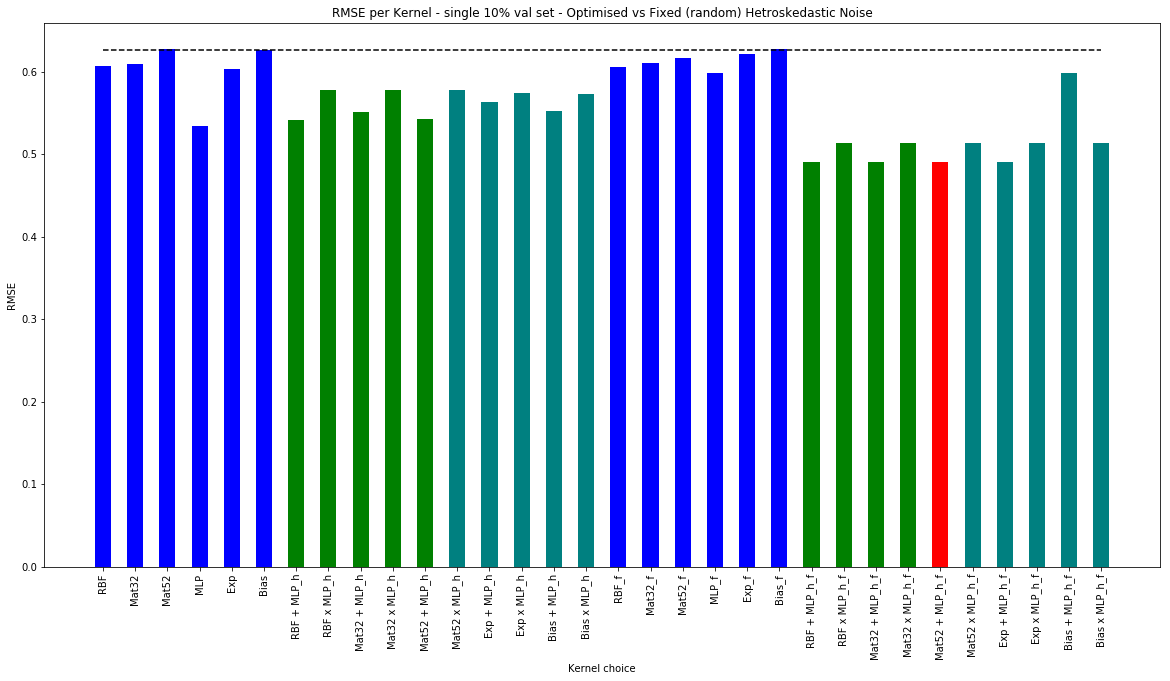

In [11]:
x = range(len(errs))
best_ind = np.argmin(errs)
colours = ["blue"]*len(kers) + ["green"]*len(mlp_kers) + ["teal"]*len(mlp_kers)+["blue"]*len(kers) + ["green"]*len(mlp_kers) + ["teal"]*len(mlp_kers)
colours[best_ind] = "red" 
fig = plt.figure(figsize=(20,10))

plt.bar(x, errs, 0.5, color = colours)
plt.xticks(x, labels, rotation = 90)
plt.ylabel('RMSE')
plt.xlabel('Kernel choice')
plt.title('RMSE per Kernel - single 10% val set - Optimised vs Fixed (random) Hetroskedastic Noise')

# horizontal line indicating the average
plt.plot([0, x[-1]], [rand_err, rand_err], "k--")
plt.show()

##  Average over Repeated Runs

In [243]:
def GPReg_model(k, x_train, y_train, x_valid, y_valid):
    m = GPy.models.GPRegression(x_train, y_train, k)
    m.optimize()    
    y_pred, Vp = m.predict(x_valid, full_cov=False)
    err = rmse(y_valid, y_pred) 
    ll = m.objective_function()
    return (err, ll)

def GPReg_hetro_model(k, x_train, y_train, x_valid, y_valid, fix_noise=True):    
    m = GPy.models.GPHeteroscedasticRegression(x_train, y_train,  k)
    m['.*het_Gauss.variance'] = abs(np.random.normal(0, .2, x_train.shape[0])[:,None])
    if fix_noise: m.het_Gauss.variance.fix() 
    m.optimize()
    y_pred, Vp = m._raw_predict(x_valid)
    err = rmse(y_valid, y_pred)
    ll = m.objective_function()
    return (err, ll)

def evaluate_models(x_train, y_train, x_valid, y_valid, reg=[], hetro=[], opt_hetro=[]):
    error, ll = [], []
    in_dims = x_train.shape[1]
    
    list_of_good_kernels = [
              

              GPy.kern.MLP(in_dims) + GPy.kern.RBF(in_dims),                 #2
              GPy.kern.MLP(in_dims) * GPy.kern.RBF(in_dims),                 #3
              GPy.kern.MLP(in_dims) + GPy.kern.Linear(in_dims),            #4
              GPy.kern.MLP(in_dims) * GPy.kern.Linear(in_dims),            #5
              GPy.kern.MLP(in_dims) + GPy.kern.Exponential(in_dims),         #6
              GPy.kern.MLP(in_dims) * GPy.kern.Exponential(in_dims),         #7  
        
              GPy.kern.MLP(in_dims) + GPy.kern.Bias(in_dims),                #6
              GPy.kern.MLP(in_dims) * GPy.kern.Bias(in_dims),                #7
        
              GPy.kern.Linear(in_dims),                                      #8
              GPy.kern.RBF(in_dims),                                         #9
              GPy.kern.MLP(in_dims)]                                         #10
    
    
    # GP Regression
    for i in reg:
        k = list_of_good_kernels[i]
        ret = GPReg_model(k, x_train, y_train, x_valid, y_valid)
        error.append(ret[0])
        ll.append(ret[1])
        
    # Hetroscedastic Noise - random
    for i in hetro:
        k = list_of_good_kernels[i]
        ret = GPReg_hetro_model(k, x_train, y_train, x_valid, y_valid, True)
        error.append(ret[0])
        ll.append(ret[1])
        
    # Hetroscedastic Noise - optimised
    for i in opt_hetro:
        k = list_of_good_kernels[i]
        ret = GPReg_hetro_model(k, x_train, y_train, x_valid, y_valid, False)
        error.append(ret[0])
        ll.append(ret[1])
    
    # Random Mean assignment:
    r = [random.uniform(1, 4) for i in xrange(len(y_valid))]
    error.append(rmse(y_valid, r))
#     error.append(rmse(y_valid, np.mean(y_valid)))
    return error, ll 

all_labels = ["MLP+RBF", "MLPxRBF", "MLP+Linear", "MLPxLinear", "MLP+Exp", "MLPxExp", "MLP+Bias", "MLPxBias", "Linear", "RBF", "MLP"]

## Average over many repeated runs 

In [8]:
def plot_bars(RMS_reps, title, labels):
    
    RMS_reps = np.vstack(RMS_reps)
    means = RMS_reps.mean(axis=0)
    stds = RMS_reps.std(axis=0)

    colours = ["teal"]*(len(labels)-1) + ["green"]
    xbar = range(len(means))

    fig, ax = plt.subplots(figsize=(20, 8))
    rects = ax.bar(xbar, means, color = colours,  yerr=stds)
    ax.set_xticks(xbar)
    ax.set_xticklabels(labels, rotation=70)
    ax.set_ylabel('Average RMSE')
#     ax.set_ylim([0,0.8])
    ax.set_xlabel('Kernel choice')
    ax.set_title(title)
#     autolabel(rects1)
    """Attach a text label above each bar displaying its height"""
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + 0.2+ rect.get_width()/2., 1.05*height,'%0.3f' % height, ha='center', va='bottom')
    plt.show()


>> Occupation weighted vectors
finished fold:  10


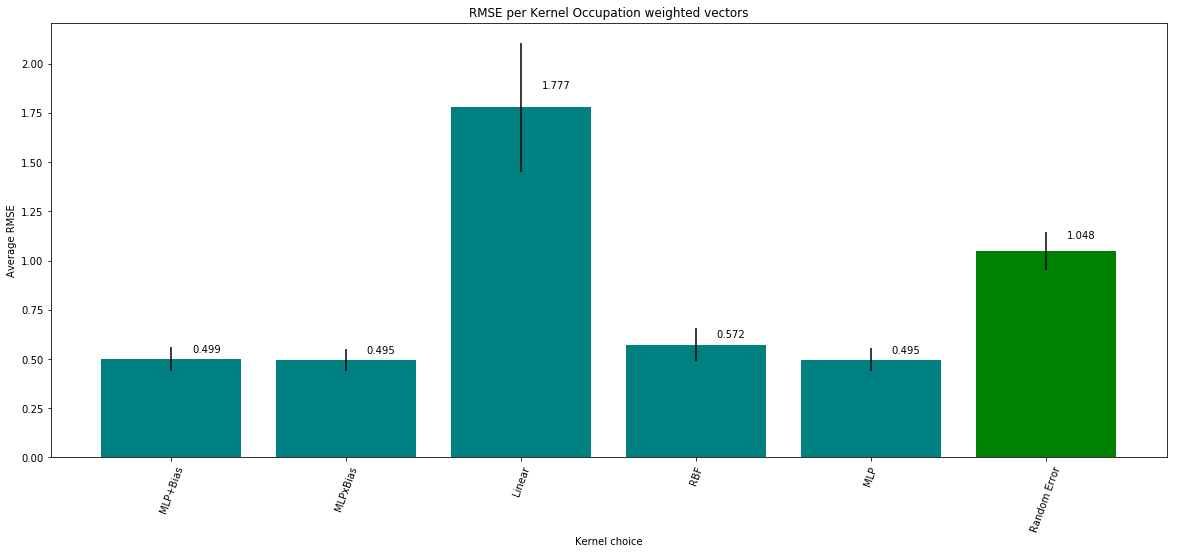

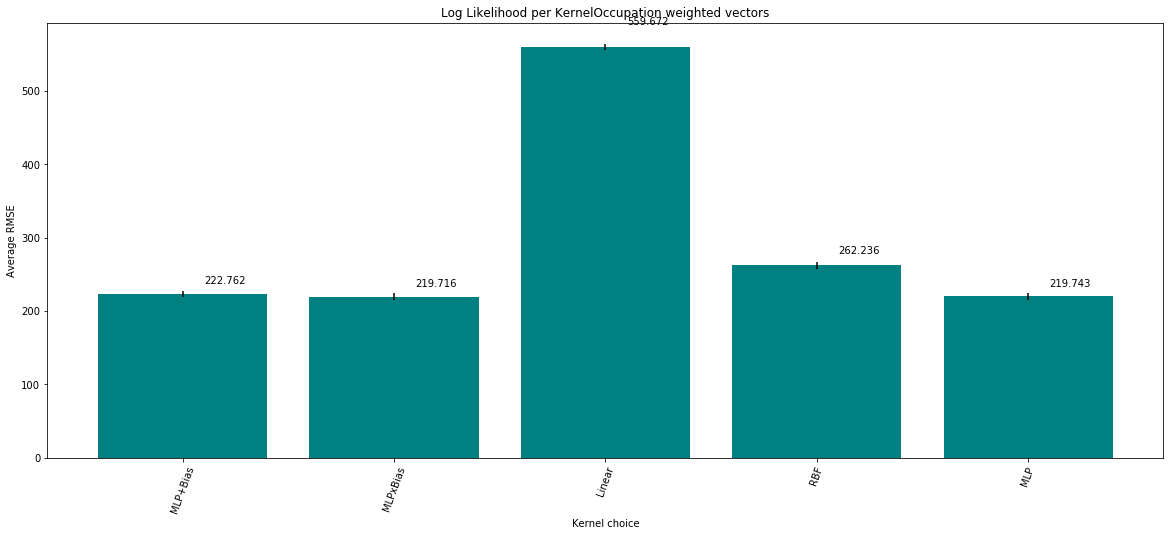

In [244]:
def evaluate_kfolds(input_data, title=""):
    
    print "\n>>", title
    (X, test, y) = input_data
    cols = test.columns[2:]
  
    skills = test.columns[2:2+35]
    know = test.columns[37:37+33]
    ability = test.columns[37+33:]

    #cols = skills.append(know)
    in_dims = cols.shape[0]
    
    # Create multiple random Validation sets
#     msk = [i for i in range(X.shape[0])]
    # RMS_reps_o, ll_reps_o = [], []
    # n_validation_set = int(np.floor(X.shape[0]*val_size))
    # for rep in xrange(5):
    #     print rep, 

    #     random.shuffle(msk)
    #     x_train = X.iloc[msk[n_validation_set:]][cols].as_matrix()
    #     x_valid = X.iloc[msk[:n_validation_set]][cols].as_matrix()
    #     y_train = y.values[msk[n_validation_set:]].reshape(x_train.shape[0], 1)
    #     y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)

    # Actual K-fold CV
    k_fold = KFold(n_splits=10)
    
    # Continue to shuffle the dataset X before cv. 
    msk = [i for i in range(X.shape[0])]
    random.shuffle(msk)
    shuffled_training_X = X.iloc[msk][cols]
    shuffled_y = y.iloc[msk]
    
    RMS_reps_o, ll_reps_o = [], []

    for cnt, (train_indices, test_indices) in enumerate(k_fold.split(X)):
        x_train = shuffled_training_X.iloc[train_indices][cols].as_matrix()
        x_valid = shuffled_training_X.iloc[test_indices][cols].as_matrix()
        y_train = shuffled_y.values[train_indices].reshape(x_train.shape[0], 1)
        y_valid = shuffled_y.values[test_indices].reshape(x_valid.shape[0], 1)

        reg = xrange(6,11)
        hetro = [] #[0,1,3,4]

        ret = evaluate_models(x_train, y_train, x_valid, y_valid, reg, hetro)

        RMS_reps_o.append(ret[0])
        ll_reps_o.append(ret[1])
        
    print "finished fold: ", cnt+1
    labels = [all_labels[j] for j in reg] + [all_labels[j]+"_hf" for j in hetro] + ["Random Error"]
    t1 = 'RMSE per Kernel ' + title
    plot_bars(RMS_reps_o, t1, labels)
    t2 = 'Log Likelihood per Kernel' + title
    plot_bars(ll_reps_o, t2, labels)

# Occupation weighted vectors:
evaluate_kfolds(data_o, "Occupation weighted vectors" )  

# # DWA weighted (only) vectors:
# evaluate_kfolds(data, "DWA weighted (only) vectors")


## Replicate using unit normalised, 0 mean, weighted features:

0 1 2 3 4 finished:  4


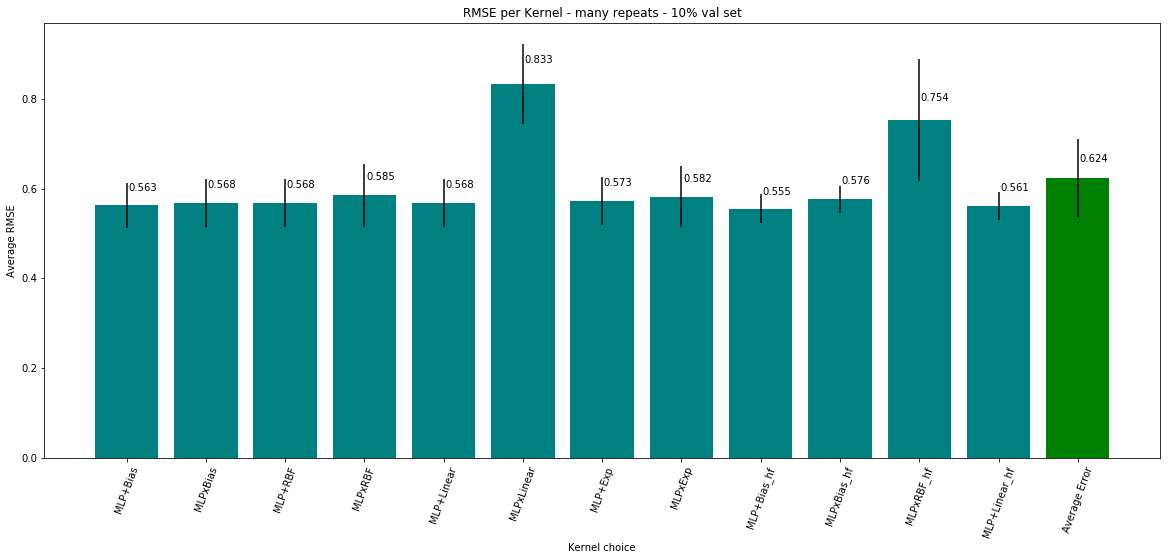

In [19]:
(X, test, y) = data_o

cols = test.columns[2:]
test_n = (test[cols]-X[cols].mean())/X[cols].std()
normalized_test = pd.merge(test[['DWA ID', 'DWA GT Rating']], test_n, how='left', left_index=True, right_index=True)
normalized_test

X_n = (X[cols]-X[cols].mean())/X[cols].std()
norm_X = pd.merge(X[['DWA ID', 'DWA GT Rating']], X_n, how='left', left_index=True, right_index=True)

X = norm_X.copy()
msk = [i for i in range(X.shape[0])]

RMS_reps_o = []
n_validation_set = int(np.floor(X.shape[0]*val_size))
for rep in xrange(5):
    print rep, 
    random.shuffle(msk)

    x_train = X.iloc[msk[n_validation_set:]][cols].as_matrix()
    x_valid = X.iloc[msk[:n_validation_set]][cols].as_matrix()

    y_train = y.values[msk[n_validation_set:]].reshape(x_train.shape[0], 1)
    y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)

    reg = xrange(0,8)
    hetro = [0,1,3,4]
    
    ret = evaluate_models(x_train, y_train, x_valid, y_valid, reg, hetro)
    
    RMS_reps_o.append(ret[0])
    ll_reps_o.append(ret[1])
    
print "finished: ", rep
labels = [all_labels[j] for j in reg] + [all_labels[j]+"_hf" for j in hetro] + ["Average Error"]
plot_bars(RMS_reps_o, 'RMSE per Kernel - many repeats - 10% val set', labels)

## Investigate ARD Features

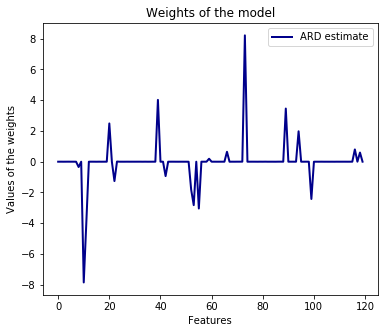

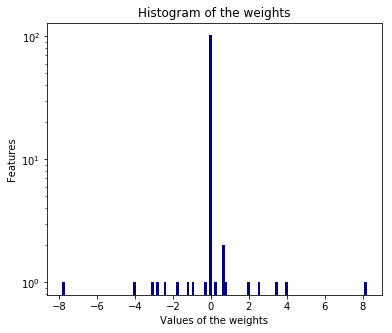

In [48]:
from sklearn.linear_model import ARDRegression
 
# Fit Automatic Relevance Determination Regression
n_samples, n_features = x_train.shape
clf = ARDRegression(compute_score=True)
clf.fit(x_train, y_train)

plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(clf.coef_, color='darkblue', linestyle='-', linewidth=2, label="ARD estimate")
# plt.plot(ols.coef_[0], color='yellowgreen', linestyle=':', linewidth=2, label="OLS estimate")
# plt.plot(w, color='orange', linestyle='-', linewidth=2, label="Ground truth")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc=1)

# #############################################################################
# Plot the true weights, the estimated weights, the histogram of the
# weights, and predictions with standard deviations
plt.figure(figsize=(6, 5))
plt.title("Histogram of the weights")
plt.hist(clf.coef_, bins=120, color='navy', log=True)
# plt.scatter(clf.coef_[relevant_features], 5 * np.ones(len(relevant_features)), color='gold', marker='o', label="Relevant features")
plt.ylabel("Features")
plt.xlabel("Values of the weights")
plt.legend(loc=1)

# plt.figure(figsize=(6, 5))
# plt.title("Marginal log-likelihood")
# plt.plot(clf.scores_, color='navy', linewidth=2)
# plt.ylabel("Score")
# plt.xlabel("Iterations")

In [324]:
# USE THE ARD THRESHOLD TO SELECT FEATURES:
threshold = 0.01
category = ["skill"]*35 +["knowledge"]*33+["ability"]*52

# SKILLS, KNOWLEDGE, ABILITIES
print "FEATURES Selected:\n"
b = abs(clf.coef_) > threshold
for cnt, i in enumerate(test.columns[2:]):
    if b[cnt]: 
        print "%0.3f, %s, %s" %(abs(clf.coef_)[cnt], category[cnt], i)


FEATURES Selected:

0.346, skill, Instructing
7.844, skill, Learning Strategies
3.993, skill, Management of Financial Resources
2.485, skill, Persuasion
1.258, skill, Quality Control Analysis
4.015, knowledge, Clerical
0.936, knowledge, Customer and Personal Service
1.815, knowledge, History and Archeology
2.822, knowledge, Law and Government
3.042, knowledge, Mechanical
0.192, knowledge, Physics
0.644, knowledge, Therapy and Counseling
8.208, ability, Depth Perception
3.453, ability, Mathematical Reasoning
1.976, ability, Number Facility
2.421, ability, Peripheral Vision
0.798, ability, Visualization
0.594, ability, Written Comprehension


## Only use ARD Features in GP

Reduce # features to: 18 
0 1 2 3 4 5 6 7 8 9

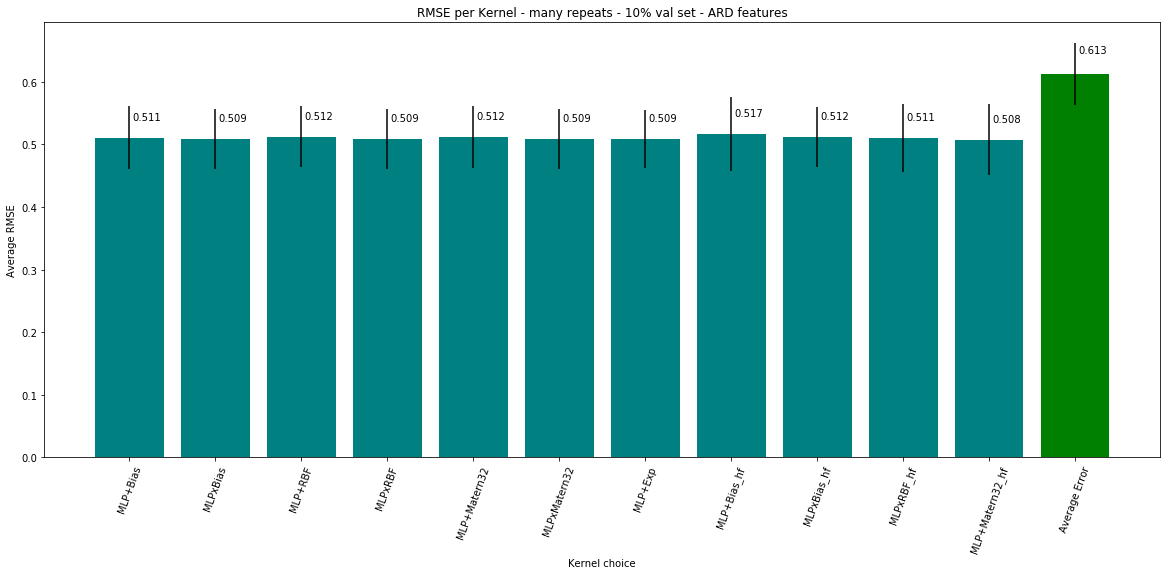

In [464]:
print "Reduce # features to: %s " % sum(abs(clf.coef_) > threshold)
(X, test, y) = data
msk = [i for i in range(X.shape[0])]
n_validation_set = int(np.floor(X.shape[0]*val_size))

RMS_reps_ard = []
for rep in xrange(10):
    print rep, 
    random.shuffle(msk)
    
    x_train_ard = X.iloc[msk[n_validation_set:]][cols].as_matrix()[:,abs(clf.coef_) > threshold]
    x_valid_ard = X.iloc[msk[:n_validation_set]][cols].as_matrix()[:,abs(clf.coef_) > threshold]
    
    y_train = y.values[msk[n_validation_set:]].reshape(x_train_ard.shape[0], 1)
    y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)

    reg = xrange(0,7)
    hetro = [0, 1, 3, 4]
    RMS_reps_ard.append(evaluate_models(x_train_ard, y_train, x_valid_ard, y_valid, reg, hetro))

labels = [all_labels[j] for j in reg] + [all_labels[j]+"_hf" for j in hetro] + ["Average Error"]
plot_bars(RMS_reps_ard, 'RMSE per Kernel - many repeats - 10% val set - ARD features', labels) 


## Low Rank approximations:

10 422.048410336
20 252.10817698
30 179.521230129
40 136.755978116
50 104.814211042
60 79.0883964107
70 59.8877525801
80 43.6337369461
90 30.2896943142
100 19.5509440502
110 10.3510662054
120 2.355073081e-11


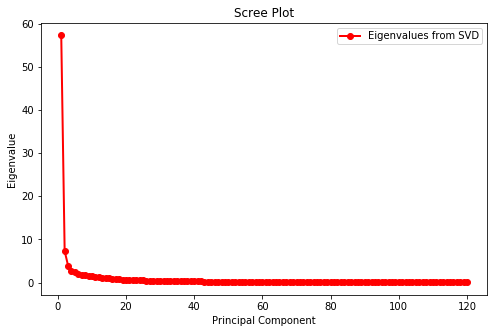

In [382]:
num_vars = x_train.shape[1]
U, S, V = np.linalg.svd(x_train, full_matrices=0)
eigvals = S # **2 / np.cumsum(S)[-1]

fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(num_vars) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3)

import sklearn.decomposition as sk_decomp

def low_rank_it(U, S, V, rank):
    return np.dot(U[:,:rank], np.dot(np.diag(S[:rank]), V[:rank,:]))
    
for i in xrange(120):
    low_rank = low_rank_it(U, S, V, i+1)
    if (i+1) %10 == 0:
        print i+1, sum(sum(np.abs(x_train - low_rank)))

In [472]:
def evaluate_low_rank(data, its = 10):
    
    (X, test, y) = data
    msk = [i for i in range(X.shape[0])]
    n_validation_set = int(np.floor(X.shape[0]*val_size))

    RMS_reps_svd = {120:[], 'random':[]}
    for rep in xrange(its):
        print rep, 
        random.shuffle(msk)
        x_train = X.iloc[msk[n_validation_set:]][cols].as_matrix()
        x_valid = X.iloc[msk[:n_validation_set]][cols].as_matrix()
        y_train = y.values[msk[n_validation_set:]].reshape(x_train.shape[0], 1)
        y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)

        print "comps = ",
        for comps in xrange(0,101,20):
            if comps == 0: comps=1
            print comps,
            svd = sk_decomp.TruncatedSVD(n_components= comps)
            x_train_svd = svd.fit_transform(x_train)
            x_valid_svd = svd.transform(x_valid)
            [error, compare] = evaluate_models(x_train_svd, y_train, x_valid_svd, y_valid, [0])
            try:
                RMS_reps_svd[comps].append(error)
            except KeyError as e:
                RMS_reps_svd[comps] = [error]

        #all variables:
        print "120"
        [error, compare] = evaluate_models(x_train, y_train, x_valid, y_valid, [0])
        RMS_reps_svd[120].append(error)
        RMS_reps_svd['random'].append(compare)
    print "finished", rep
    return RMS_reps_svd

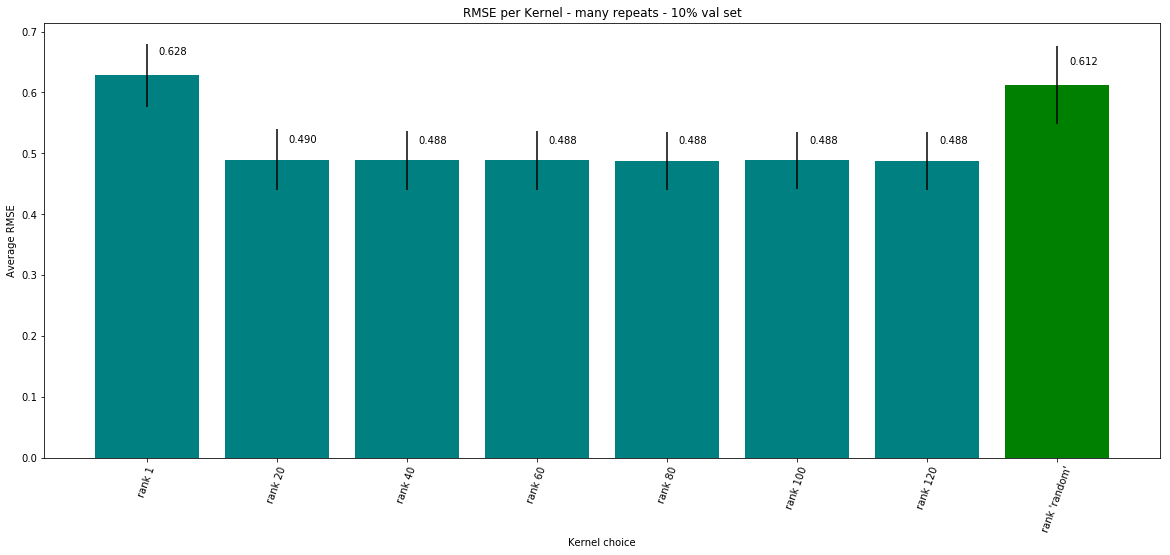

In [470]:
# RMS_reps_svd = evaluate_low_rank(data)    
RMS_reps_svd_ = np.array([j for i,j in sorted(RMS_reps_svd.items())])
labels = ["rank " + repr(i) for i,j in sorted(RMS_reps_svd.items())]

plot_bars(RMS_reps_svd_.T, 'RMSE per Kernel - many repeats - 10% val set', labels)


0 comps =  1 20 40 60 80 100 120
1 comps =  1 20 40 60 80 100 120
2 comps =  1 20 40 60 80 100 120
3 comps =  1 20 40 60 80 100 120
4 comps =  1 20 40 60 80 100 120
5 comps =  1 20 40 60 80 100 120
6 comps =  1 20 40 60 80 100 120
7 comps =  1 20 40 60 80 100 120
8 comps =  1 20 40 60 80 100 120
9 comps =  1 20 40 60 80 100 120
10 comps =  1 20 40 60 80 100 120
11 comps =  1 20 40 60 80 100 120
12 comps =  1 20 40 60 80 100 120
13 comps =  1 20 40 60 80 100 120
14 comps =  1 20 40 60 80 100 120
15 comps =  1 20 40 60 80 100 120
16 comps =  1 20 40 60 80 100 120
17 comps =  1 20 40 60 80 100 120
18 comps =  1 20 40 60 80 100 120
19 comps =  1 20 40 60 80 100 120
20 comps =  1 20 40 60 80 100 120
21 comps =  1 20 40 60 80 100 120
22 comps =  1 20 40 60 80 100 120
23 comps =  1 20 40 60 80 100 120
24 comps =  1 20 40 60 80 100 120
finished 24


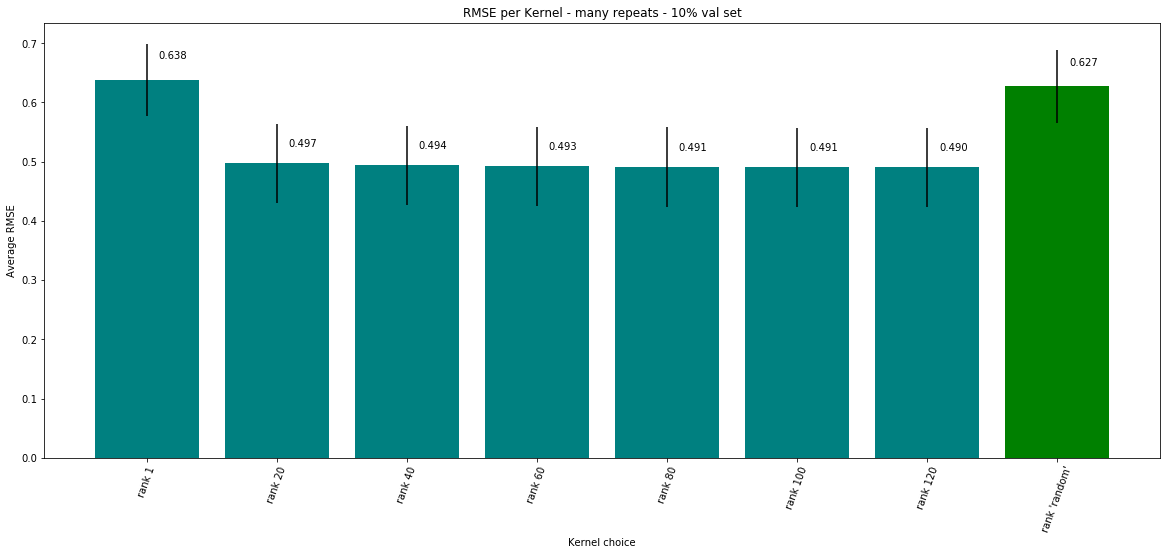

In [486]:
# Low Rank with Employment weights

RMS_reps_svd = evaluate_low_rank(data_o, 25)
RMS_reps_svd_ = np.array([j for i,j in sorted(RMS_reps_svd.items())])
labels = ["rank " + repr(i) for i,j in sorted(RMS_reps_svd.items())]

plot_bars(RMS_reps_svd_.T, 'RMSE per Kernel - many repeats - 10% val set', labels)

## Make Some Predictions:

In [31]:
# Use final model on the actual Test set of DWAs: 

(X, test, y) = data_o
x_train_o = X[cols].as_matrix()
y_train = y.values.reshape(x_train_o.shape[0], 1)
x_test_o = test[cols].as_matrix()

(X, test, y) = data
x_train = X[cols].as_matrix()
x_test = test[cols].as_matrix()

llhood, models = [], []
for i in xrange(10):
    sig = random.random()
    sig_w = random.randint(0, 1000)
    in_dims = x_train.shape[1]

    k1 = GPy.kern.MLP(in_dims, variance = sig, weight_variance= sig_w) + GPy.kern.Linear(in_dims)
    k2 = GPy.kern.MLP(in_dims, variance = sig, weight_variance= sig_w) + GPy.kern.RBF(in_dims)
  
    
    for k in (k1, k2):
        m = GPy.models.GPRegression(x_train, y_train, k)
        m.optimize()    
        models.append(m)
        llhood.append(m.objective_function())

        m = GPy.models.GPRegression(x_train_o, y_train, k)
        m.optimize()    
        models.append(m)
        llhood.append(m.objective_function())

print np.mean(llhood[::4]), np.min(llhood[::4])
print np.mean(llhood[1::4]), np.min(llhood[1::4])
print np.mean(llhood[2::4]), np.min(llhood[2::4])
print np.mean(llhood[3::4]), np.min(llhood[3::4])

241.28599513 241.143056216
242.561514703 242.019360386
240.704690067 239.847589673
244.142448583 241.263530176


In [32]:
# Use final model on the actual Test set of DWAs: 

(X, test, y) = data_o
x_train_o = X[cols].as_matrix()
y_train = y.values.reshape(x_train_o.shape[0], 1)
x_test_o = test[cols].as_matrix()

llhood, models = [], []
for i in xrange(10):
    sig = random.random()
    sig_w = random.randint(0, 1000)
    in_dims = x_train.shape[1]
    k = GPy.kern.MLP(in_dims, variance = sig, weight_variance= sig_w) + GPy.kern.RBF(in_dims)
    m = GPy.models.GPRegression(x_train_o, y_train, k)
    m.optimize()    
    models.append(m)
    llhood.append(m.objective_function())
print np.mean(llhood), np.min(llhood)

In [34]:
best_mod = np.argmin(llhood)
print best_mod, np.min(llhood)
m = models[best_mod]
y_pred, Vp = m.predict(x_test, full_cov=False)
# y_pred, Vp = m._raw_predict(x_test)
y_pred.shape

0 241.210408889


(1753, 1)

## Merge y_test and DWA

In [61]:
(df, test, y) = data_o

# pd.concat([test['DWA ID'], y_pred.view(np.recarray)], axis=1)
test['y_pred'] = y_pred
for_logan_test = test[['DWA ID', 'y_pred']]
for_logan_train = df[['DWA ID', 'DWA GT Rating']]

for_logan_test.to_csv(os.path.join(datasets, 'FoEmployment/Analysis_of_ONET_Tasks/dwa_auto_test.csv'))
for_logan_train.to_csv(os.path.join(datasets, 'FoEmployment/Analysis_of_ONET_Tasks/dwa_auto_train.csv'))

In [ ]:
(df, test, y) = data_o

df['IWA ID'] = df['DWA ID'].str.slice(0,-4)    # create IWA ID
df['WA ID'] = df['DWA ID'].str.slice(0,-8)     # create WA ID

WAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/Work Activities.txt'), sep='\t')[['Element ID', 'Element Name']]
WAref.rename(columns = {'Element ID':'WA ID', 'Element Name':'WA Title'}, inplace = True)
WAref.drop_duplicates(inplace=True)

col_names = test.columns[2:]
coefs_for_all = {}
counts = {}


In [480]:
# print X.shape
# print x_train.shape
# print y_train.shape
# print x_valid.shape
# print y_valid.shape
# print x_test.shape
# print y_pred.shape
# print in_dims

In [24]:
training_categories1 = {"0-1":[], "1-2":[], "2-3":[], "3-4":[]}
training_categories2 = {"0":[], "1":[], "2":[], "3":[], "4":[]}
training_tasks = len(y_train)

for i in y_train:
#     print i
    
    if i < 1: cat = "0-1"
    elif i <2: cat = "1-2"
    elif i <3: cat = "2-3"
    else: cat = "3-4"
    training_categories1[cat].append(i)
    
    if i < 0.5: cat = "0"
    elif i <1.5: cat = "1"
    elif i <2.5: cat = "2"
    elif i <3.5: cat = "3"        
    else: cat = "4"
    training_categories2[cat].append(i)

for cat, dwas in sorted(training_categories1.items()):
    print "Category= %s. Training Number of DWAs= %s. Percentage of DWAs= %0.2f." % (cat, len(dwas), (len(dwas)/float(training_tasks)*100))
    
print "\n"
for cat, dwas in sorted(training_categories2.items()):
    print "Category= %s. Training Number of DWAs= %s. Percentage of DWAs= %0.2f." % (cat, len(dwas), (len(dwas)/float(training_tasks)*100))


Category= 0-1. Training Number of DWAs= 0. Percentage of DWAs= 0.00.
Category= 1-2. Training Number of DWAs= 52. Percentage of DWAs= 16.56.
Category= 2-3. Training Number of DWAs= 162. Percentage of DWAs= 51.59.
Category= 3-4. Training Number of DWAs= 100. Percentage of DWAs= 31.85.


Category= 0. Training Number of DWAs= 0. Percentage of DWAs= 0.00.
Category= 1. Training Number of DWAs= 10. Percentage of DWAs= 3.18.
Category= 2. Training Number of DWAs= 125. Percentage of DWAs= 39.81.
Category= 3. Training Number of DWAs= 147. Percentage of DWAs= 46.82.
Category= 4. Training Number of DWAs= 32. Percentage of DWAs= 10.19.


# Interpretibility 

- Using Pearson's coefficient

- And Average Gradients

## only have 120 x 314 training data - not 350?

positive
('Control Precision', 71, 0.050747551938892251, 0.050747551938892251)
('Rate Control', 101, 0.040573030687374757, 0.040573030687374757)
('Operation and Control', 18, 0.039843711682168, 0.039843711682168)
('Manual Dexterity', 88, 0.026235794655516828, 0.026235794655516828)
('Wrist-Finger Speed', 117, 0.017012713765300624, 0.017012713765300624)
('Multilimb Coordination', 91, 0.016513792628866587, 0.016513792628866587)
('Arm-Hand Steadiness', 68, 0.013409987092436985, 0.013409987092436985)
('Equipment Maintenance', 5, 0.0096747986263719787, 0.0096747986263719787)
('Reaction Time', 102, 0.0086064130371295931, 0.0086064130371295931)
('Troubleshooting', 33, 0.003201947940463743, 0.003201947940463743)

negative
('History and Archeology', 52, -0.22809094994947535, -0.22809094994947535)
('Sociology and Anthropology', 64, -0.22544459828189758, -0.22544459828189758)
('Philosophy and Theology', 58, -0.22536201931422051, -0.22536201931422051)
('Therapy and Counseling', 66, -0.2236107729443

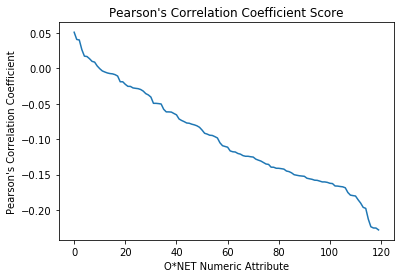

In [290]:
(X, test, y) = data
x_train = X[cols].as_matrix()
# X_n = (x_train-x_train.mean(axis=0))/x_train.std(axis=0)

col_names = test.columns[2:]
coefs_for_all = []
for cnt, column in enumerate(X.T):
    coef, p = pearsonr(column, y_train.reshape(314,))
    coefs_for_all.append((col_names[cnt], cnt, coef, coef))

l = [y[2] for y in sorted(coefs_for_all, key=lambda x: x[2])][::-1]

plt.title("Pearson's Correlation Coefficient Score")
plt.ylabel("Pearson's Correlation Coefficient")
plt.xlabel("O*NET Numeric Attribute")
plt.plot(xrange(120), l)

print "positive"
for i in [y for y in sorted(coefs_for_all, key=lambda x: x[2])[-10:]][::-1]:
    print i
print "\nnegative"
for i in [y for y in sorted(coefs_for_all, key=lambda x: x[2])[:10]]:
    print i



## Try interpretting per WA

'Monitor Processes, Materials, or Surroundings'

 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning:reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/scipy/stats/stats.py:3013: RuntimeWarning:invalid value encountered in double_scalars
 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/scipy/stats/stats.py:3003: RuntimeWarning:invalid value encountered in double_scalars



4.A.1.a.1 Getting Information
positive
('Sales and Marketing', 63, 0.083352901871024496, 0.767740369922147)
('Building and Construction', 37, 0.074043215805696547, 0.79312945840764226)
('Troubleshooting', 33, 0.029113952267631631, 0.91796585972760325)
('Quality Control Analysis', 22, 0.023503838806338849, 0.933737600843076)
('Multilimb Coordination', 91, 1.8482120808761467e-06, 0.99999478417696441)
negative
('Therapy and Counseling', 66, -0.55858520271651524, 0.030437354936677662)
('Philosophy and Theology', 58, -0.50806703034148359, 0.053157106271059074)
('Sociology and Anthropology', 64, -0.4721325801063973, 0.075572964527432285)
('History and Archeology', 52, -0.46061190861726281, 0.084011189839287306)
('Complex Problem Solving', 2, -0.41038813001000957, 0.12866213789665279)

4.A.1.a.2 Monitor Processes, Materials, or Surroundings
positive
('Arm-Hand Steadiness', 68, 0.31635944279015021, 0.17417432547191769)
('Manual Dexterity', 88, 0.30725300452171717, 0.18758816198878953)
('Contr

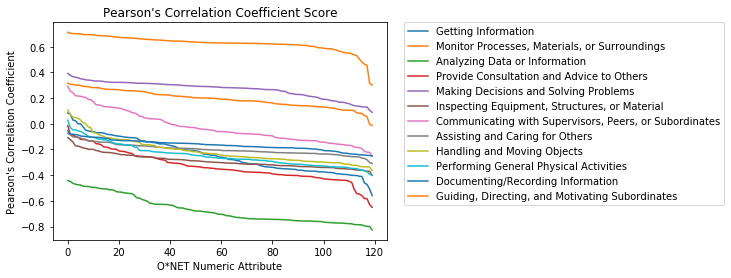

In [5]:
(df, test, y) = data

df['IWA ID'] = df['DWA ID'].str.slice(0,-4)    # create IWA ID
df['WA ID'] = df['DWA ID'].str.slice(0,-8)     # create WA ID

WAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/Work Activities.txt'), sep='\t')[['Element ID', 'Element Name']]
WAref.rename(columns = {'Element ID':'WA ID', 'Element Name':'WA Title'}, inplace = True)
WAref.drop_duplicates(inplace=True)

col_names = test.columns[2:]
coefs_for_all = {}
counts = {}

for wa in df['WA ID'].unique():
    coefs_for_all[wa] = []
    
    wa_subset = df[df['WA ID'] == wa][col_names].values
    y_subset = y[df['WA ID'] == wa].reshape(wa_subset.shape[0],)
    counts[wa] = wa_subset.shape[0]
    for cnt, column in enumerate(wa_subset.T):
        coef, p = pearsonr(column, y_subset)
        coefs_for_all[wa].append((col_names[cnt], cnt, coef, p))

display = 5
plt.title("Pearson's Correlation Coefficient Score")
plt.ylabel("Pearson's Correlation Coefficient")
plt.xlabel("O*NET Numeric Attribute")

for wa, coefs in coefs_for_all.items():
    if counts[wa] < 10: continue
    text = WAref[WAref['WA ID']==wa].reset_index()['WA Title'][0]
    print "\n", wa, text
#     if wa != "4.A.2.a.3": continue
        
    l = [y[2] for y in sorted(coefs, key=lambda x: x[2])][::-1]
    a = plt.plot(xrange(120), l, label= text)
    

    print "positive"
    for i in [y for y in sorted(coefs, key=lambda x: x[2])[-display:]][::-1]:
        print i
    print "negative"
    for i in [y for y in sorted(coefs, key=lambda x: x[2])[:display]]:
        print i
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Sanity Checking output:

In [69]:
(X, test, y) = data   # Doesn't matter which data - y_pred is the best predictions

## ADD DWA and IWA titles:
DWAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/DWA Reference.txt'), sep='\t')[['DWA ID', 'DWA Title']]
test2 = pd.merge(test, DWAref,  how='left', left_on=['DWA ID'], right_on = ['DWA ID'])

test2['IWA ID'] = test2['DWA ID'].str.slice(0,-4)    # create IWA ID
test2['WA ID'] = test2['DWA ID'].str.slice(0,-8)     # create WA ID

IWAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/IWA Reference.txt'), sep='\t')[['IWA ID', 'IWA Title']]
test2 = pd.merge(test2, IWAref,  how='left', left_on=['IWA ID'], right_on = ['IWA ID'])

WA = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/Work Activities.txt'), sep='\t')
WA.rename(columns = {'Element ID':'WA ID', 'Element Name':'WA Title'}, inplace = True)
# WA[['WA IM Value', 'WA IM SE']] = WA[['Data Value', 'Standard Error']]  # This is per Occupation. 

WA = WA[WA['Scale ID'] == "IM"][['WA ID', 'WA Title']]
WA.drop_duplicates(inplace=True)
test2 = pd.merge(test2, WA,  how='left', left_on=['WA ID'], right_on = ['WA ID'])

In [65]:
# Most and Least Automatable Inferred Task Ratings: 

number_displayed = 10

######################################DO WE ADD TRAIN SET HERE: will show a larger spread of automation scores. 

appended_list = []
for (cnt, row) in test2.iterrows():
    appended_list.append((y_pred[cnt][0], Vp[cnt][0], row['DWA ID'], row['DWA Title'], row['IWA ID'], row['IWA Title'], row['WA ID'], row['WA Title'] ))

least_dwa, most_dwa = set([]), set([])

least = [y for y in sorted(appended_list, key=lambda x: x[0])[:number_displayed]]
most = [y for y in sorted(appended_list, key=lambda x: x[0])[-number_displayed:]]

print "PREDICTED LEAST AUTOMATABLE: "
for i in [y for y in sorted(appended_list, key=lambda x: x[0])[:number_displayed]]:
    least_dwa.add(i[2][:-4])
    print "P: %0.3f of ID: %s, DWA: %s" % (i[0], i[2], i[3])

print "\nPREDICTED MOST AUTOMATABLE: "
for i in [y for y in sorted(appended_list, key=lambda x: x[0])[-number_displayed:]]:
    most_dwa.add(i[2][:-4])
    print "P: %0.3f of ID: %s, DWA: %s" % (i[0], i[2], i[3])

PREDICTED LEAST AUTOMATABLE: 
P: 1.768 of ID: 4.A.4.b.3.I02.D11, DWA: Teach humanities courses at the college level.
P: 1.773 of ID: 4.A.4.b.3.I02.D03, DWA: Teach social science courses at the college level.
P: 1.775 of ID: 4.A.4.b.4.I09.D08, DWA: Manage organizational or program finances.
P: 1.787 of ID: 4.A.4.b.3.I02.D07, DWA: Teach online courses.
P: 1.801 of ID: 4.A.2.b.2.I03.D04, DWA: Develop promotional strategies for religious organizations.
P: 1.809 of ID: 4.A.4.b.3.I02.D04, DWA: Lead classes or community events.
P: 1.817 of ID: 4.A.2.b.6.I01.D02, DWA: Plan conferences, programs, or special events.
P: 1.828 of ID: 4.A.4.b.4.I07.D04, DWA: Manage human resources activities.
P: 1.838 of ID: 4.A.2.a.1.I08.D01, DWA: Evaluate scholarly materials.
P: 1.852 of ID: 4.A.4.b.4.I12.D17, DWA: Direct administrative or support services.

PREDICTED MOST AUTOMATABLE: 
P: 3.359 of ID: 4.A.2.b.1.I10.D05, DWA: Select production input materials.
P: 3.359 of ID: 4.A.1.b.2.I06.D11, DWA: Inspect items

In [194]:
# LEAST AUTOMATABLE:
# print len(set([i[3] for i in least])), " DWAs:", set([i[3] for i in least]), "\n"
print len(set([i[5] for i in least])), " IWAs:", set([i[5] for i in least]), "\n"


8  IWAs: set(['Manage budgets or finances.', 'Plan events or programs.', 'Maintain current knowledge in area of expertise.', 'Compile records, documentation, or other data.', 'Teach academic or vocational subjects.', 'Evaluate scholarly work.', 'Direct organizational operations, activities, or procedures.', 'Develop business or marketing plans.']) 



In [195]:
# MOST AUTOMATABLE:
# print len(set([i[3] for i in most])), " DWAs:", set([i[3] for i in most]), "\n"
print len(set([i[5] for i in most])), " IWAs:", set([i[5] for i in most]), "\n"


8  IWAs: set(['Operate office equipment.', 'Perform administrative or clerical activities.', 'Reconcile financial data.', 'Create decorative objects or parts of objects.', 'Stock supplies or products.', 'Operate industrial processing or production equipment.', 'Determine values or prices of goods or services.', 'Maintain sales or financial records.']) 



## Experiment 3: 

Compute the number or percentage of each predicted categorical automation score.

- just the test set? Or training set also? 


In [196]:
len(appended_list)
categories1 = {"0-1":[], "1-2":[], "2-3":[], "3-4":[]}
categories2 = {"0":[], "1":[], "2":[], "3":[], "4":[]}

for i in appended_list:
#     print i[0]
    
    if i[0] < 1: cat = "0-1"
    elif i[0] <2: cat = "1-2"
    elif i[0] <3: cat = "2-3"
    else: cat = "3-4"
    categories1[cat].append((i[2], i[3]))
    
    if i[0] < 0.5: cat = "0"
    elif i[0] <1.5: cat = "1"
    elif i[0] <2.5: cat = "2"
    elif i[0] <3.5: cat = "3"        
    else: cat = "4"
    categories2[cat].append((i[2], i[3]))
    
    
total_tasks = len(appended_list)

for cat, dwas in sorted(categories1.items()):
    print "Category= %s. Inferred Number of DWAs= %s. Percentage of DWAs= %0.2f." % (cat, len(dwas), (len(dwas)/float(total_tasks)*100))
    
print "\n"
for cat, dwas in sorted(categories2.items()):
    print "Category= %s. Inferred Number of DWAs= %s. Percentage of DWAs= %0.2f." % (cat, len(dwas), (len(dwas)/float(total_tasks)*100))
        

Category= 0-1. Inferred Number of DWAs= 0. Percentage of DWAs= 0.00.
Category= 1-2. Inferred Number of DWAs= 66. Percentage of DWAs= 3.76.
Category= 2-3. Inferred Number of DWAs= 1504. Percentage of DWAs= 85.80.
Category= 3-4. Inferred Number of DWAs= 183. Percentage of DWAs= 10.44.


Category= 0. Inferred Number of DWAs= 0. Percentage of DWAs= 0.00.
Category= 1. Inferred Number of DWAs= 0. Percentage of DWAs= 0.00.
Category= 2. Inferred Number of DWAs= 669. Percentage of DWAs= 38.16.
Category= 3. Inferred Number of DWAs= 1084. Percentage of DWAs= 61.84.
Category= 4. Inferred Number of DWAs= 0. Percentage of DWAs= 0.00.


## Add task importance weight to the DWAs inorder to compute automation of DWAs

In [212]:
################## tasks ########################################
tasks = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/Task Statements.txt'), sep='\t')
tasks = tasks[['O*NET-SOC Code', 'Task ID', 'Task']]

reduce_tasks = tasks['O*NET-SOC Code'].unique()#[:2]
tasks = tasks[tasks['O*NET-SOC Code'].isin(reduce_tasks)]      # reduce the task matrix for now :)
print tasks.shape, "UNIQUE tasks: ", len(tasks['Task ID'].unique())  # All tasks are unique to Occupation it seems
tasks.head()


################## task dwa ########################################
taskDWA = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/Tasks to DWAs.txt'), sep='\t')
taskDWA = taskDWA[['Task ID', 'DWA ID']]
print taskDWA.shape, "UNIQUE DWA: ", len(taskDWA['DWA ID'].unique()) 
taskDWA.head()


################## iwa and wa ########################################
df = pd.merge(tasks, taskDWA,  how='left', left_on=['Task ID'], right_on = ['Task ID']).sort_values(by = 'Task ID')
df = df[df['DWA ID'].notnull()]
df['IWA ID'] = df['DWA ID'].str.slice(0,-4)    # create IWA ID
df['WA ID'] = df['DWA ID'].str.slice(0,-8)     # create WA ID


################## dwa titles #####################################
DWAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/DWA Reference.txt'), sep='\t')[['DWA ID', 'DWA Title']]
taskDWA2 = pd.merge(df, DWAref,  how='left', left_on=['DWA ID'], right_on = ['DWA ID'])

################## iwa title ########################################
IWAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/IWA Reference.txt'), sep='\t')[['IWA ID', 'IWA Title']]
df2 = pd.merge(df, IWAref,  how='left', left_on=['IWA ID'], right_on = ['IWA ID'])
cols = ['O*NET-SOC Code', 'Task ID', 'DWA ID', 'IWA ID', 'WA ID']
df2 = df2[cols]
print df2.shape, "UNIQUE DWA: ", len(df2['DWA ID'].unique())
df2.head()

################## task importance ratings #####################
task_rates = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/Task Ratings.txt'), sep='\t')
task_im = task_rates[task_rates['Scale ID'] == 'IM']
task_im.rename(columns = {'Data Value':'Task IM'}, inplace = True)
task_im = task_im[['Task ID', 'Task IM']].sort_values('Task ID')
task_im

################## remove task if no importance rating ##########
df3 = pd.merge(df2, task_im, how='left', left_on=['Task ID'], right_on = ['Task ID'])
print df3.shape
df3 = df3[df3['Task IM'].notnull()]   
print df3.shape  # 500 missing Task IM 
df3

################## task importance by dwa #####################
by = ['DWA ID']
task_im_by_dwa = df3.groupby(by).sum().reset_index()[['DWA ID','Task IM']]
task_im_by_dwa.rename(columns = {'Task IM' : 'IM per DWA Sum'}, inplace = True)

################## normalise task importance by dwa #################
task_im_by_dwa['Norm IM per DWA'] = task_im_by_dwa['IM per DWA Sum']/task_im_by_dwa['IM per DWA Sum'].sum()
task_im_by_dwa

################## inference on test set (1700) #####################

(19566, 3) UNIQUE tasks:  19566
(22838, 2) UNIQUE DWA:  2070
(22838, 5) UNIQUE DWA:  2070
(22838, 6)
(22365, 6)


,DWA ID,IM per DWA Sum,Norm IM per DWA
0,4.A.1.a.1.I01.D01,19.62,0.000221
1,4.A.1.a.1.I01.D02,14.09,0.000159
2,4.A.1.a.1.I01.D03,23.55,0.000266
3,4.A.1.a.1.I01.D04,37.45,0.000423
4,4.A.1.a.1.I02.D01,12.16,0.000137
5,4.A.1.a.1.I02.D02,17.67,0.000199
6,4.A.1.a.1.I02.D03,10.68,0.000121
7,4.A.1.a.1.I02.D04,160.21,0.001808
8,4.A.1.a.1.I02.D05,51.64,0.000583
9,4.A.1.a.1.I02.D06,97.92,0.001105


# Proposed Further: 

The above results, use the Skills, Knowledge and Abilities of Occupations. 

Genereted a feature vector per DWA by: 

- normalised Task Importance per occupation 
- normalised Task Importance per DWA 

since tasks are roughly unique to occupations. 

Then averaged the skills vectors over the DWA level. 

add: 
- NN - pyTorch. 

- remove "unsure" from survey?  
